In [4]:
import cv2 
import pandas 
import numpy as np
import json 

In [5]:
import matplotlib.pyplot as plt
import os
import ipdb

In [6]:
import h5py
import dill as pkl

In [8]:
import graphviz 
from graphviz import Digraph 
import tqdm

In [9]:
import pdb

In [12]:
image_dir = '../datasets/vg/VG_100K'
image_list_file = '../datasets/vg/image_data.json'
VG_dicts_file = '../datasets/vg/VG-SGG-dicts-with-attri.json'
VG_SGG_file = '../datasets/vg/VG-SGG-with-attri.h5'

In [13]:
with open(image_list_file, 'r') as fp: 
    image_list = json.load(fp)
print(len(image_list))
corrupted_ims = ['1592.jpg', '1722.jpg', '4616.jpg', '4617.jpg']
corrupted_idx = []
for n, img in enumerate(image_list): 
    basename = img['url'].split('/')[-1]
    if basename in corrupted_ims: 
        corrupted_idx.append(n)
[image_list.remove(image_list[n]) for n in corrupted_idx]
print(len(image_list))

with open(VG_dicts_file, 'r') as fp: 
    VG_dicts = json.load(fp)

108073
108073


In [14]:
print(corrupted_idx)

[]


In [15]:
rel_recall='..//sess_802/aoe_ra_rel_embed_aug_embed_v3_avg_dropout0.1_angle_rm_0.3_epoch12'
with open(rel_recall, 'rb') as fp: 
    prd = pkl.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../results/sess_802/aoe_ra_rel_embed_aug_embed_v3_avg_dropout0.1_angle_rm_0.3_epoch12'

In [16]:
VG = h5py.File(VG_SGG_file)
split = VG['split'][:]
split_mask = split == 2
split_mask &= VG['img_to_first_box'][:] >= 0
split_mask &= VG['img_to_first_rel'][:] >= 0
inds = np.where(split_mask)[0]

/usr/local/envs/sg_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [17]:
def get_IoU(boxA, boxB): 
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    if x1 > x2 or y1 > y2: 
        return 0 
    interArea = (x2 - x1) * (y2 - y1)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea/float(boxAArea + boxBArea - interArea)
    
    return 0 if iou < 0 else iou 

In [18]:
def get_gt_idx(boxes, labels, gt_boxes, gt_labels, iou_thresh=0.5):
    n_boxes = len(boxes)
    idx = [-1] * n_boxes 
    pred = [False] * n_boxes 
    for n in range(n_boxes): 
        ious = []
        for m in range(len(gt_boxes)): 
            ious.append(get_IoU(boxes[n], gt_boxes[m]))
        args = np.argsort(ious)[::-1]
        for m in range(len(args)): 
            if ious[args[m]] > iou_thresh:
                if gt_labels is not None: 
                    if labels[args[m]] == gt_labels[args[m]]: 
                        idx[n] = args[m]
                        break
                else: 
                    idx[n] = args[m]
                    break
    return idx

In [19]:
def compare_rels(predObjId_to_gtObjId, pred_rels, gt_rels): 
    rel_true = [False] * len(pred_rels)
    for n in range(len(pred_rels)): 
        rel = np.copy(pred_rels[n])
        rel[0] = predObjId_to_gtObjId[rel[0]]
        rel[1] = predObjId_to_gtObjId[rel[1]]
        if -1 in rel: 
            continue
        if list(rel) in gt_rels.tolist(): 
            rel_true[n] = True
    return rel_true
        

In [20]:
def get_FalseNegative_rels(gtObjId_to_predObjId, pred_rels, gt_rels): 
    FN_rels = [] 
    for n in range(len(gt_rels)): 
        rel = gt_rels[n]
        rel[0] = gtObjId_to_predObjId[rel[0]]
        rel[1] = gtObjId_to_predObjId[rel[1]]
        if list(rel) not in pred_rels.tolist(): 
            FN_rels.append(rel)
    return FN_rels

In [21]:
def get_object_names(obj_labels): 
    count_dicts = {}
    unique, counts = np.unique(obj_labels, return_counts=True)
    for n in range(len(unique)): 
        count_dicts[unique[n]] = 1 if counts[n] > 1 else 0
    names = [None] * len(obj_labels)
    for n, lb in enumerate(obj_labels): 
        name = VG_dicts['idx_to_label'][str(lb)]
        names[n] = name if count_dicts[lb] == 0 else name + '-{}'.format(count_dicts[lb])
        count_dicts[lb] += 1 
    return names 

In [22]:
def draw_objects(img, boxes, names, labels, colors=plt.get_cmap('tab10').colors, thickness=4, pad=1):
    n_boxes = len(boxes)
    new_img = np.copy(img)
    assert len(boxes) == len(labels), 'The number of boxes must equal to the number of labels'
    for n in range(n_boxes):
        cl = [int(cl*256) for cl in colors[labels[n]%len(colors)]]
        new_img = cv2.rectangle(new_img, tuple(boxes[n][0:2]), tuple(boxes[n][2:4]), cl, thickness)
        text = names[n]
        (text_width, text_height) = cv2.getTextSize(text,                                                    
                                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                                   fontScale=2, 
                                                   thickness=thickness)[0]
 
        text_box = [(boxes[n][0] + text_width + pad, boxes[n][1]+pad), (boxes[n][0]-pad, boxes[n][1] - text_height)]
        new_img = cv2.rectangle(new_img, text_box[0], text_box[1], cl, cv2.FILLED)
        new_img = cv2.putText(new_img, text, tuple(boxes[n][0:2]), 
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              color=(255, 255, 255), 
                              fontScale=1, 
                              lineType=4,
                              thickness=thickness)
    return new_img 

In [23]:
def draw_objects_TF(img, boxes, names, labels, predObjId_to_gtObjId, colors=plt.get_cmap('tab10').colors, thickness=4, pad=1):
    n_boxes = len(boxes)
    new_img = np.copy(img)
    assert len(boxes) == len(labels), 'The number of boxes must equal to the number of labels'
    for n in range(n_boxes):
        cl = [int(cl*256) for cl in colors[labels[n]%len(colors)]]
        cl = (0, 0, 255) if predObjId_to_gtObjId[n] == -1 else (0, 255, 0)
        new_img = cv2.rectangle(new_img, tuple(boxes[n][0:2]), tuple(boxes[n][2:4]), cl, thickness)
        text = names[n]
        (text_width, text_height) = cv2.getTextSize(text,                                                    
                                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                                   fontScale=1, 
                                                   thickness=thickness)[0]
 
        text_box = [(boxes[n][0], boxes[n][1]), (boxes[n][0] + text_width + pad, boxes[n][1] + text_height)]
        new_img = cv2.rectangle(new_img, text_box[0], text_box[1], cl, cv2.FILLED)
        new_img = cv2.putText(new_img, text, tuple((text_box[0][0], text_box[1][1])), 
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              color=(255, 255, 255), 
                              fontScale=1, 
                              lineType=4,
                              thickness=thickness)
    return new_img 

In [24]:
def draw_objects_box(img, boxes, names, labels, predObjId_to_gtObjId, colors=plt.get_cmap('tab10').colors, thickness=4, pad=1):
    n_boxes = len(boxes)
    new_img = np.copy(img)
    assert len(boxes) == len(labels), 'The number of boxes must equal to the number of labels'
    for n in range(n_boxes):
        cl = [int(cl*256) for cl in colors[labels[n]%len(colors)]]
        cl = (0, 0, 255) if predObjId_to_gtObjId[n] == -1 else (0, 255, 0)
        new_img = cv2.rectangle(new_img, tuple(boxes[n][0:2]), tuple(boxes[n][2:4]), cl, thickness)
        text = names[n]
        (text_width, text_height) = cv2.getTextSize(text,                                                    
                                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                                   fontScale=1, 
                                                   thickness=thickness)[0]
    return new_img 

In [25]:
def draw_objects_TF_query(img, boxes, names, labels, predObjId_to_gtObjId, query, colors=plt.get_cmap('tab10').colors, thickness=4, pad=1):
    n_boxes = len(boxes)
    new_img = np.copy(img)
    assert len(boxes) == len(labels), 'The number of boxes must equal to the number of labels'
    for n in range(n_boxes):
        if n not in query: 
            continue
        cl = [int(cl*256) for cl in colors[labels[n]%len(colors)]]
        cl = (0, 0, 255) if predObjId_to_gtObjId[n] == -1 else (0, 255, 0)
        new_img = cv2.rectangle(new_img, tuple(boxes[n][0:2]), tuple(boxes[n][2:4]), cl, thickness)
        text = names[n]
        (text_width, text_height) = cv2.getTextSize(text,                                                    
                                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                                   fontScale=1, 
                                                   thickness=thickness)[0]
 
        text_box = [(boxes[n][0], boxes[n][1]), (boxes[n][0] + text_width + pad, boxes[n][1] + text_height)]
        new_img = cv2.rectangle(new_img, text_box[0], text_box[1], cl, cv2.FILLED)
        new_img = cv2.putText(new_img, text, tuple((text_box[0][0], text_box[1][1])), 
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              color=(255, 255, 255), 
                              fontScale=1, 
                              lineType=4,
                              thickness=thickness)
    return new_img 

In [26]:
def draw_relations(img, boxes, rels, colors=plt.get_cmap('tab10').colors, thickness=4, pad=1):
    n_rels = len(rels)
    new_img = np.copy(img)
    if len(rels) == 0: 
        return new_img
    assert np.max(rels[:, 0:2]) <= len(boxes), 'Out of index in objects'
    
    for n in range(n_rels):
        cl = [int(cl*256) for cl in colors[rels[n, 2]%len(colors)]]
        sub_idx = rels[n][0]
        obj_idx = rels[n][1]
        
        sub_box = boxes[sub_idx, :]
        obj_box = boxes[obj_idx, :]
        pred_box = (sub_box[0:2] + obj_box[0:2])/2
        pred_box = pred_box.astype(np.int)
        
        new_img = cv2.arrowedLine(new_img, tuple(sub_box[0:2]), tuple(obj_box[0:2]), cl, thickness)
        
        text = VG_dicts['idx_to_predicate'][str(rels[n, 2])]
        
        (text_width, text_height) = cv2.getTextSize(text,                                                    
                                                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                                   fontScale=1, 
                                                   thickness=thickness)[0] 
        text_box = [(pred_box[0]+text_width+pad, pred_box[1]+pad), (pred_box[0]-pad, pred_box[1] - text_height)]
        new_img = cv2.rectangle(new_img, text_box[0], text_box[1], cl, cv2.FILLED)
        new_img = cv2.putText(new_img, text, tuple(pred_box[0:2]), 
                              fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                              color=(255, 255, 255), 
                              fontScale=1, 
                              lineType=1,
                              thickness=thickness)
    return new_img 

In [27]:
def resize_boxes(img, boxes, im_scale=(1024.,)):
    new_boxes = np.copy(boxes)
    h, w = img.shape[0:2]
    if len(im_scale) == 2: 
        scale_w = im_scale[1] / w
        scale_h = im_scale[0] / h 
    else:
        if h > w: 
            scale_h = im_scale[0] / h 
            scale_w = scale_h 
        else:
            scale_w = im_scale[0] / w 
            scale_h = scale_w 
    #ipdb.set_trace()
    new_boxes[:, [0, 2]] = new_boxes[:, [0, 2]] / scale_w
    new_boxes[:, [1, 3]] = new_boxes[:, [1, 3]] / scale_h
    new_boxes = new_boxes.astype(np.int)
    return  new_boxes

def get_rels_from_pred(prd): 
    predicate_idx = np.argmax(np.copy(prd['rel_scores']), axis=1)
    idx = np.where(predicate_idx > 0)
    rel_inds = np.copy(prd['pred_rel_inds'])
    rels = np.concatenate((rel_inds[idx], predicate_idx[idx][:, None]), axis=1)
    return rels

In [28]:
def get_gt_boxes(boxes): 
    new_boxes = np.zeros(boxes.shape)
    new_boxes[:, 0] = boxes[:, 0] - boxes[:, 2]/2
    new_boxes[:, 1] = boxes[:, 1] - boxes[:, 3]/2
    new_boxes[:, 2] = boxes[:, 0] + boxes[:, 2]/2
    new_boxes[:, 3] = boxes[:, 1] + boxes[:, 3]/2
    return new_boxes.astype(np.int)

https://cs.stanford.edu/people/rak248/VG_100K/2343729.jpg
(600, 385, 3)
(600, 385, 3)


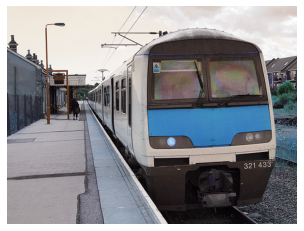

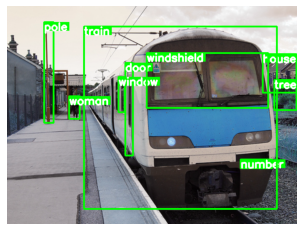

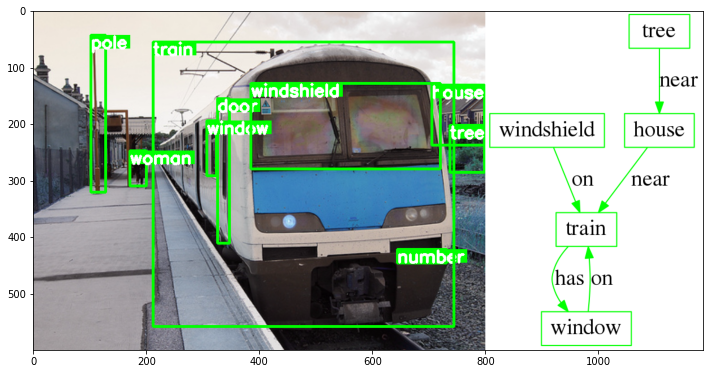

In [36]:
idx = 0
print(image_list[inds[idx]]['url'])
img = cv2.imread(os.path.join(image_dir, image_list[inds[idx]]['url'].split('/')[-1]))
fig,ax=plt.subplots()
ax.axis('off')
plt.imshow(img)

first_idx = VG['img_to_first_rel'][inds[idx]]
last_idx = VG['img_to_last_rel'][inds[idx]]
gt_rels = VG['relationships'][first_idx:last_idx+1]
predicates = VG['predicates'][first_idx:last_idx+1]

first_idx = VG['img_to_first_box'][inds[idx]]
last_idx = VG['img_to_last_box'][inds[idx]]
gt_rels = np.concatenate((gt_rels-first_idx, predicates), axis=1)

gt_boxes = VG['boxes_1024'][first_idx:last_idx+1]
gt_boxes = get_gt_boxes(gt_boxes)
gt_boxes = resize_boxes(img, gt_boxes)
gt_labels = VG['labels'][first_idx:last_idx+1]

# pd = prd[idx]
# boxes = pd['pred_boxes']
# boxes = resize_boxes(img, boxes)
# rels = get_rels_from_pred(pd)
# labels = pd['pred_classes']
boxes = gt_boxes 
rels = gt_rels 
labels = gt_labels

################################################################
img_size = img.shape[0:2]
#print(img_size)
img = cv2.resize(img, (800, 600))
gt_boxes = resize_boxes(img, gt_boxes, im_scale=img_size)
#print(boxes)
boxes = resize_boxes(img, boxes, im_scale=img_size)
#print(boxes)
################################################################

obj_idx = get_gt_idx(boxes, labels, gt_boxes, gt_labels)
predObjId_to_gtObjId = {} 
for n in range(len(labels)): 
    predObjId_to_gtObjId[n] = obj_idx[n]
obj_idx = get_gt_idx(gt_boxes, gt_labels, boxes, None)
gtObjId_to_predObjId = {} 
for n in range(len(gt_labels)): 
    gtObjId_to_predObjId[n] = obj_idx[n]   
    
disp_labels = list(labels)
for n in gtObjId_to_predObjId:
    disp_labels[gtObjId_to_predObjId[n]] = gt_labels[n][0]
names = get_object_names(disp_labels)   

rel_true = compare_rels(predObjId_to_gtObjId, rels, gt_rels)

FN_rels = get_FalseNegative_rels(gtObjId_to_predObjId, rels, gt_rels)
if len(FN_rels) > 0: 
    FN_rels = np.stack(FN_rels, axis=0)
    full_rels = np.concatenate((rels, FN_rels), axis=0)
    rel_true = rel_true + [False] * len(FN_rels)
else:
    full_rels = rels 

img1 = draw_objects_TF(img, boxes, names, disp_labels, predObjId_to_gtObjId, thickness=4)
#img1 = draw_objects(img, boxes, names, labels,thickness=2)
#img1 = draw_relations(img1, gt_boxes, gt_rels, thickness=2)
fig,ax=plt.subplots()
ax.axis('off')
ax.imshow(img1)

dot = Digraph(engine='dot')
dot.attr('graph', rotate = '0', dpi='300',rankdir='TB', size='4,2')
dot.attr('node', height='0.1', fontsize='20')
dot.attr('edge', fontsize='20')
for n in np.unique(full_rels[:, 0:2]): 
    color = 'green' if predObjId_to_gtObjId[n] >= 0 else 'red'
    dot.node(names[n], shape='rectangle', color=color, )
for n in range(len(rels)): 
    rel = full_rels[n]
    color = 'green' if rel_true[n] else 'red'
    dot.edge(names[rel[0]], names[rel[1]], label=VG_dicts['idx_to_predicate'][str(rel[2])], color=color)
for n in range(len(FN_rels)): 
    rel = FN_rels[n]
    color = 'red'
    dot.edge(names[rel[0]], names[rel[1]], label=VG_dicts['idx_to_predicate'][str(rel[2])], color=color, style='dashed')

dot.format = 'png'
dot.render('round-table.gv', view=True)

graph = cv2.imread('round-table.gv.png')

print(graph.shape)
graph = cv2.resize(graph, dsize=(0, 0), fx=600.0/graph.shape[0], fy=600.0/graph.shape[0])
print(graph.shape)

merged_img = np.concatenate((img1, graph), axis=1)

merged_img.shape
plt.figure(figsize=(12,9))
plt.imshow(merged_img)

In [37]:
print(names)
print(predObjId_to_gtObjId)

['door', 'house', 'number', 'pole', 'train', 'tree', 'window', 'windshield', 'woman']
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


In [38]:
cv2.imwrite('0_left_graph.png', merged_img)

True

True

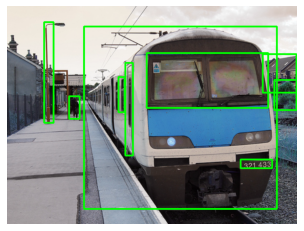

In [39]:
img1 = draw_objects_box(img, boxes, names, disp_labels, predObjId_to_gtObjId, thickness=4)
#img1 = draw_objects(img, boxes, names, labels,thickness=2)
#img1 = draw_relations(img1, gt_boxes, gt_rels, thickness=2)
fig,ax=plt.subplots()
ax.axis('off')
ax.imshow(img1)
cv2.imwrite('0_boxes.png', img1)

In [40]:
print(VG_dicts['label_to_idx']['man'])
print(VG_dicts['label_to_idx']['horse'])
print(VG_dicts['predicate_to_idx']['riding'])

78
64
38


In [41]:
image_list[inds[465]]['url'].split('/')[-1]

'2343185.jpg'

In [42]:
cv2.imwrite('1338_merged.png', merged_img)

True

In [43]:
def load_fmap(fname): 
    fmap = np.load(fname)
    fmap = np.mean(fmap, axis=(0,1))
    #fmap = fmap * (fmap > 0) # ReLU 
    fmap = fmap - fmap.min()  
    fmap /= fmap.max()
    return fmap 
    
def resize_map(fmap, size): 
    return cv2.resize(fmap, size)

def load_mask(fname): 
    masks = np.load(fname)
    return masks 

def load_inds(fname): 
    rel_inds = np.load(fname)
    return rel_inds[:, 1:]

def get_mask(masks, rel_inds, query_rel): 
    idx = rel_inds.tolist().index(query_rel)
    return masks[idx, 0, :, :], idx

def get_predicate(rels, query_rel): 
    idx = rels[:, 0:2].tolist().index(query_rel)
    return rels[idx, 2]

def get_union(box1, box2): 
    ubox = [0, 0, 0, 0]
    
    ubox[0] = min(box1[0], box2[0])
    ubox[1] = min(box1[1], box2[1])
    ubox[2] = max(box1[2], box2[2])
    ubox[3] = max(box1[3], box2[3])
    return ubox

In [44]:
get_union([10, 10, 30 ,40], [5, 15, 25, 60])

[5, 10, 30, 60]

In [45]:
gt_boxes

array([[326, 156, 347, 411],
       [705, 132, 798, 238],
       [644, 422, 731, 446],
       [102,  44, 128, 321],
       [212,  56, 744, 558],
       [737, 203, 798, 286],
       [307, 195, 324, 292],
       [385, 129, 720, 280],
       [171, 248, 200, 310]])

In [46]:
indices = [2186, 2532, 5935, 6780, 7005, 10796, 11340, 465] 
queries = [[8, 3], [13, 1], [5, 8], [0, 1], [9, 1], [1, 0], [9, 6], [5, 4]]

In [47]:
indices = [465, 573, 1516, 1516, 2283, 2751, 2883, 3475, 3475, 3938, 6714, 6714, 6873, 6971, 7132, 7549, 7552, 7849, 7881, 7881, 9053, 9053, 10244, 13481, 13623, 13998, 14106, 15532, 17390, 17472, 17718, 18046, 19165, 19830, 20245, 20331, 20331, 20331, 20469, 20904, 21201, 21239, 21420, 23086, 24651, 24911, 25618, 25707]
queries = [[5, 4], [6, 4], [14, 11], [14, 24], [4, 3], [8, 7], [2, 0], [8, 5], [7, 4], [8, 5], [16, 8], [13, 10], [5, 2], [5, 3], [9, 7], [6, 4], [6, 5], [4, 2], [2, 1], [13, 1], [3, 2], [4, 1], [8, 1], [5, 1], [2, 1], [7, 6], [7, 5], [6, 4], [8, 6], [7, 1], [10, 0], [13, 5], [5, 4], [7, 3], [2, 4], [16, 5], [8, 5], [7, 6], [4, 2], [11, 6], [12, 8], [3, 2], [2, 1], [14, 4], [12, 5], [9, 7], [10, 4], [5, 2]]

In [50]:
small_objs = ['plate', 'bottle', 'cup', 'fruit' ,'pot','orange','banana','glass', 'bowl', 'vase', 'lamp']
deformable_objs = ['dog', 'cat', 'animal', 'bird', 'man', 'woman', 'horse', 'cow']

In [51]:
sub_cls = 'animal' #'man'
obj_cls = 'cow' #'horse'
save_path = './URA/{}_{}'.format(sub_cls, obj_cls)
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [58]:
dir_fmap = '../checkpoints/iba0.02_s2_inv_prop0.03_power0.5_sum_v3-predcls/rib/'

In [60]:
n = 1
idx = indices[n]
overlay = 0.4
idx = indices[n]
query_rel = queries[n]
print(image_list[inds[idx]]['url'])
img = cv2.imread(os.path.join(image_dir, image_list[inds[idx]]['url'].split('/')[-1]))

first_idx = VG['img_to_first_rel'][inds[idx]]
last_idx = VG['img_to_last_rel'][inds[idx]]
gt_rels = VG['relationships'][first_idx:last_idx+1]
predicates = VG['predicates'][first_idx:last_idx+1]

first_idx = VG['img_to_first_box'][inds[idx]]
last_idx = VG['img_to_last_box'][inds[idx]]

gt_rels = np.concatenate((gt_rels-first_idx, predicates), axis=1)

gt_boxes = VG['boxes_1024'][first_idx:last_idx+1]
gt_boxes = get_gt_boxes(gt_boxes)
gt_boxes = resize_boxes(img, gt_boxes)
gt_labels = VG['labels'][first_idx:last_idx+1]


#a_pd = a_prd[idx]
#a_boxes = a_pd['pred_boxes']
#a_boxes = resize_boxes(img, a_boxes)
#a_rels = get_rels_from_pred(a_pd)
#a_labels = a_pd['pred_classes']

# load fmap
a_fmap = load_fmap(dir_fmap + '{}_fmap.npy'.format(idx))
a_mask = load_mask(dir_fmap + '{}_mask.npy'.format(idx))
a_inds = load_inds(dir_fmap + '{}_inds.npy'.format(idx))

union_box = get_union(a_boxes[query_rel[0]], a_boxes[query_rel[1]])
mask, rel_idx = get_mask(a_mask, a_inds, query_rel)
mask = resize_map(mask[0], (union_box[2] - union_box[0] + 1, union_box[3] - union_box[1] + 1))
a_fmap = resize_map(a_fmap, (img.shape[1], img.shape[0]))

heatmap = a_fmap[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1] * mask


heatmap = np.uint8(heatmap * 255)

https://cs.stanford.edu/people/rak248/VG_100K/2343053.jpg


NameError: name 'a_boxes' is not defined

In [52]:
for n in range(len(indices)):
    overlay = 0.4
    idx = indices[n]
    query_rel = queries[n]
    print(image_list[inds[idx]]['url'])
    img = cv2.imread(os.path.join(image_dir, image_list[inds[idx]]['url'].split('/')[-1]))

    first_idx = VG['img_to_first_rel'][inds[idx]]
    last_idx = VG['img_to_last_rel'][inds[idx]]
    gt_rels = VG['relationships'][first_idx:last_idx+1]
    predicates = VG['predicates'][first_idx:last_idx+1]

    first_idx = VG['img_to_first_box'][inds[idx]]
    last_idx = VG['img_to_last_box'][inds[idx]]

    gt_rels = np.concatenate((gt_rels-first_idx, predicates), axis=1)

    gt_boxes = VG['boxes_1024'][first_idx:last_idx+1]
    gt_boxes = get_gt_boxes(gt_boxes)
    gt_boxes = resize_boxes(img, gt_boxes)
    gt_labels = VG['labels'][first_idx:last_idx+1]


    a_pd = a_prd[idx]
    a_boxes = a_pd['pred_boxes']
    a_boxes = resize_boxes(img, a_boxes)
    a_rels = get_rels_from_pred(a_pd)
    a_labels = a_pd['pred_classes']

    # load fmap
    a_fmap = load_fmap(dir_fmap + '{}_fmap.npy'.format(idx))
    a_mask = load_mask(dir_famp + '{}_mask.npy'.format(idx))
    a_inds = load_inds(dir_fmap + '{}_inds.npy'.format(idx))

    union_box = get_union(a_boxes[query_rel[0]], a_boxes[query_rel[1]])
    mask, rel_idx = get_mask(a_mask, a_inds, query_rel)
    mask = resize_map(mask[0], (union_box[2] - union_box[0] + 1, union_box[3] - union_box[1] + 1))
    a_fmap = resize_map(a_fmap, (img.shape[1], img.shape[0]))
    try: 
        heatmap = a_fmap[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1] * mask
    except:
        continue
        
    heatmap = np.uint8(heatmap * 255)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_WINTER)
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_a = np.copy(img)
    img_a[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1, :] += np.uint8(overlay * heatmap)
    predicate = get_predicate(a_rels, query_rel)
    cv2.imwrite('./URA/{}_{}/{}_a_{}.png'.format(sub_cls, obj_cls, idx, 
                                                 VG_dicts['idx_to_predicate'][str(predicate)]), img_a)
    fig,ax=plt.subplots()
    ax.axis('off')
    ax.imshow(img_a)
    plt.title('Attention: {}'.format(VG_dicts['idx_to_predicate'][str(predicate)]))

    #na_fmap = resize_map(na_fmap, (img.shape[1], img.shape[0]))
    heatmap = a_fmap[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1]
    heatmap = np.uint8(heatmap * 255)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_WINTER)
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_na = np.copy(img)
    img_na[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1, :] += np.uint8(overlay * heatmap)

    obj_idx = get_gt_idx(a_boxes, a_labels, gt_boxes, gt_labels)
    predObjId_to_gtObjId = {} 
    for n in range(len(a_labels)): 
        predObjId_to_gtObjId[n] = obj_idx[n]
    obj_idx = get_gt_idx(gt_boxes, gt_labels, a_boxes, None)
    gtObjId_to_predObjId = {} 
    for n in range(len(gt_labels)): 
        gtObjId_to_predObjId[n] = obj_idx[n]   

    disp_labels = list(a_labels)
    for n in gtObjId_to_predObjId:
        disp_labels[gtObjId_to_predObjId[n]] = gt_labels[n][0]
    names = get_object_names(disp_labels)   

    rel_true = compare_rels(predObjId_to_gtObjId, a_rels, gt_rels)

    FN_rels = get_FalseNegative_rels(gtObjId_to_predObjId, a_rels, gt_rels)
    if len(FN_rels) > 0: 
        FN_rels = np.stack(FN_rels, axis=0)
        full_rels = np.concatenate((a_rels, FN_rels), axis=0)
        rel_true = rel_true + [False] * len(FN_rels)
    else:
        full_rels = a_rels 

    img1 = draw_objects_TF_query(img, a_boxes, names, disp_labels, predObjId_to_gtObjId, query_rel, thickness=4)
    predicate = get_predicate(gt_rels, query_rel)
    cv2.imwrite('./URA/{}_{}/{}_gt_{}.png'.format(sub_cls, obj_cls, idx, 
                                                  VG_dicts['idx_to_predicate'][str(predicate)]), img1)
    #img1 = draw_objects(img, boxes, names, labels,thickness=2)
    #img1 = draw_relations(img1, gt_boxes, gt_rels, thickness=2)
    fig,ax=plt.subplots()
    ax.axis('off')
    ax.imshow(img1)

    plt.title('GT: {}'.format(VG_dicts['idx_to_predicate'][str(predicate)]))

https://cs.stanford.edu/people/rak248/VG_100K/2343185.jpg


NameError: name 'a_prd' is not defined

In [264]:
true_thresh = 0.5
sub = VG_dicts['label_to_idx'][sub_cls] 
obj = VG_dicts['label_to_idx'][obj_cls] 
print("subj:{}, obj:{}".format(sub, obj))

subj:2, obj:12


In [265]:
indices = []
queries = []
for idx in tqdm.tqdm(range(len(inds))):
    
    a_pd = a_prd[idx]
    a_boxes = a_pd['pred_boxes']
    a_boxes = resize_boxes(img, a_boxes)
    a_rels = get_rels_from_pred(a_pd)
    a_labels = a_pd['pred_classes']
    
    first_idx = VG['img_to_first_rel'][inds[idx]]
    last_idx = VG['img_to_last_rel'][inds[idx]]
    gt_rels = VG['relationships'][first_idx:last_idx+1]
    predicates = VG['predicates'][first_idx:last_idx+1]

    first_idx = VG['img_to_first_box'][inds[idx]]
    last_idx = VG['img_to_last_box'][inds[idx]]
    gt_rels = np.concatenate((gt_rels-first_idx, predicates), axis=1)

    gt_boxes = VG['boxes_1024'][first_idx:last_idx+1]
    gt_boxes = get_gt_boxes(gt_boxes)
    #gt_boxes = resize_boxes(img, gt_boxes)
    gt_labels = VG['labels'][first_idx:last_idx+1]

    pd = prd[idx]
    boxes = pd['pred_boxes']
    #boxes = resize_boxes(img, boxes)
    rels = get_rels_from_pred(pd)
    labels = pd['pred_classes']
    names = get_object_names(labels)
    obj_idx = get_gt_idx(boxes, labels, gt_boxes, gt_labels)
    predObjId_to_gtObjId = {} 
    for n in range(len(labels)): 
        predObjId_to_gtObjId[n] = obj_idx[n]

    rel_true = compare_rels(predObjId_to_gtObjId, rels, gt_rels)
    a_rels_true = a_rels[rel_true]
    
    for n in range(len(a_rels_true)):
        rel_subObj = np.stack((a_labels[a_rels_true[n,0]],a_labels[a_rels_true[n,1]]), axis=0)
        #if [sub, obj] in rel_subObj.tolist():
        if a_labels[a_rels_true[n,0]] == sub and a_labels[a_rels_true[n,1]] == obj:
            print("idx:{}, rel_inds:{}".format(idx,a_rels_true[n,:2]))
            indices.append(idx)
            queries.append(list(a_rels_true[n,:2]))
            















  0%|          | 0/26446 [00:00<?, ?it/s]













  0%|          | 11/26446 [00:00<04:08, 106.27it/s]













  0%|          | 18/26446 [00:00<05:02, 87.47it/s] 













  0%|          | 32/26446 [00:00<04:30, 97.69it/s]













  0%|          | 45/26446 [00:00<04:16, 102.96it/s]













  0%|          | 54/26446 [00:00<04:31, 97.32it/s] 













  0%|          | 66/26446 [00:00<04:21, 100.79it/s]













  0%|          | 76/26446 [00:00<04:22, 100.53it/s]













  0%|          | 86/26446 [00:00<04:34, 95.95it/s] 













  0%|          | 100/26446 [00:00<04:10, 105.23it/s]













  0%|          | 113/26446 [00:01<04:02, 108.37it/s]













  0%|          | 125/26446 [00:01<04:01, 109.06it/s]













  1%|          | 137/26446 [00:01<03:56, 111.35it/s]













  1%|          | 150/26446 [00:01<03:50, 114.33it/s]













  1%|          | 167/26446 [00:01<03:32, 123.86it/s]













  1%|          |

  8%|▊         | 2106/26446 [00:17<02:50, 142.99it/s]













  8%|▊         | 2121/26446 [00:17<02:55, 138.25it/s]













  8%|▊         | 2136/26446 [00:17<03:02, 133.48it/s]













  8%|▊         | 2150/26446 [00:17<03:09, 128.26it/s]













  8%|▊         | 2164/26446 [00:17<03:09, 128.07it/s]













  8%|▊         | 2179/26446 [00:18<03:02, 133.01it/s]













  8%|▊         | 2196/26446 [00:18<02:51, 141.58it/s]













  8%|▊         | 2217/26446 [00:18<02:35, 155.76it/s]













  8%|▊         | 2239/26446 [00:18<02:24, 167.89it/s]













  9%|▊         | 2258/26446 [00:18<02:22, 169.61it/s]













  9%|▊         | 2276/26446 [00:18<02:31, 159.92it/s]













  9%|▊         | 2295/26446 [00:18<02:27, 163.51it/s]













  9%|▊         | 2313/26446 [00:18<02:27, 163.26it/s]













  9%|▉         | 2330/26446 [00:18<02:37, 153.07it/s]













  9%|▉         | 2346/26446 [00:19<02:36, 154.33it/s]










 17%|█▋        | 4491/26446 [00:35<03:37, 100.78it/s]













 17%|█▋        | 4505/26446 [00:35<03:22, 108.40it/s]













 17%|█▋        | 4517/26446 [00:35<03:32, 103.38it/s]













 17%|█▋        | 4528/26446 [00:35<03:36, 101.41it/s]













 17%|█▋        | 4539/26446 [00:35<03:35, 101.70it/s]













 17%|█▋        | 4552/26446 [00:35<03:28, 105.02it/s]













 17%|█▋        | 4564/26446 [00:35<03:21, 108.70it/s]













 17%|█▋        | 4576/26446 [00:35<03:15, 111.71it/s]













 17%|█▋        | 4588/26446 [00:35<03:14, 112.44it/s]













 17%|█▋        | 4600/26446 [00:36<03:12, 113.42it/s]













 17%|█▋        | 4612/26446 [00:36<03:19, 109.51it/s]













 17%|█▋        | 4626/26446 [00:36<03:06, 116.83it/s]













 18%|█▊        | 4640/26446 [00:36<02:57, 122.63it/s]













 18%|█▊        | 4655/26446 [00:36<02:48, 129.59it/s]













 18%|█▊        | 4669/26446 [00:36<02:44, 132.43it/s]










 26%|██▌       | 6856/26446 [00:52<02:04, 156.96it/s]













 26%|██▌       | 6872/26446 [00:52<02:14, 145.19it/s]













 26%|██▌       | 6887/26446 [00:52<02:33, 127.56it/s]













 26%|██▌       | 6901/26446 [00:52<02:34, 126.25it/s]













 26%|██▌       | 6915/26446 [00:52<02:38, 122.89it/s]













 26%|██▌       | 6928/26446 [00:52<03:12, 101.14it/s]













 26%|██▌       | 6939/26446 [00:53<03:14, 100.09it/s]













 26%|██▋       | 6950/26446 [00:53<03:19, 97.51it/s] 













 26%|██▋       | 6961/26446 [00:53<03:21, 96.56it/s]













 26%|██▋       | 6971/26446 [00:53<03:23, 95.92it/s]













 26%|██▋       | 6981/26446 [00:53<03:35, 90.32it/s]













 26%|██▋       | 6995/26446 [00:53<03:14, 99.96it/s]













 26%|██▋       | 7006/26446 [00:53<03:14, 99.89it/s]













 27%|██▋       | 7018/26446 [00:53<03:06, 104.45it/s]













 27%|██▋       | 7033/26446 [00:53<02:50, 114.17it/s]















 36%|███▌      | 9390/26446 [01:09<01:37, 174.99it/s]













 36%|███▌      | 9409/26446 [01:09<01:35, 178.22it/s]













 36%|███▌      | 9430/26446 [01:09<01:31, 185.70it/s]













 36%|███▌      | 9449/26446 [01:09<01:31, 185.50it/s]













 36%|███▌      | 9473/26446 [01:09<01:25, 198.22it/s]













 36%|███▌      | 9498/26446 [01:09<01:20, 209.85it/s]













 36%|███▌      | 9520/26446 [01:10<01:19, 211.91it/s]













 36%|███▌      | 9542/26446 [01:10<01:24, 200.24it/s]













 36%|███▌      | 9563/26446 [01:10<01:26, 195.10it/s]













 36%|███▌      | 9583/26446 [01:10<01:30, 185.66it/s]













 36%|███▋      | 9602/26446 [01:10<01:38, 171.77it/s]













 36%|███▋      | 9625/26446 [01:10<01:31, 182.97it/s]













 36%|███▋      | 9647/26446 [01:10<01:28, 189.09it/s]













 37%|███▋      | 9667/26446 [01:10<01:33, 180.11it/s]













 37%|███▋      | 9686/26446 [01:11<01:43, 162.66it/s]










 45%|████▌     | 11937/26446 [01:26<01:35, 151.51it/s]













 45%|████▌     | 11953/26446 [01:26<01:42, 141.53it/s]













 45%|████▌     | 11968/26446 [01:26<01:47, 135.18it/s]













 45%|████▌     | 11982/26446 [01:26<01:46, 135.78it/s]













 45%|████▌     | 12000/26446 [01:26<01:39, 145.64it/s]













 45%|████▌     | 12015/26446 [01:27<01:39, 145.09it/s]













 45%|████▌     | 12030/26446 [01:27<01:44, 137.45it/s]













 46%|████▌     | 12044/26446 [01:27<01:44, 137.85it/s]













 46%|████▌     | 12062/26446 [01:27<01:37, 147.42it/s]













 46%|████▌     | 12078/26446 [01:27<01:35, 150.56it/s]













 46%|████▌     | 12094/26446 [01:27<01:35, 150.28it/s]













 46%|████▌     | 12113/26446 [01:27<01:29, 159.43it/s]













 46%|████▌     | 12130/26446 [01:27<01:29, 159.10it/s]













 46%|████▌     | 12147/26446 [01:27<01:29, 158.93it/s]













 46%|████▌     | 12164/26446 [01:27<01:36, 148.6

 54%|█████▎    | 14153/26446 [01:43<01:47, 114.55it/s]













 54%|█████▎    | 14169/26446 [01:43<01:38, 125.01it/s]













 54%|█████▎    | 14185/26446 [01:43<01:34, 130.38it/s]













 54%|█████▎    | 14199/26446 [01:43<01:37, 126.04it/s]













 54%|█████▎    | 14212/26446 [01:44<01:56, 105.41it/s]













 54%|█████▍    | 14224/26446 [01:44<01:55, 105.79it/s]













 54%|█████▍    | 14239/26446 [01:44<01:45, 115.21it/s]













 54%|█████▍    | 14252/26446 [01:44<01:53, 107.40it/s]













 54%|█████▍    | 14264/26446 [01:44<01:55, 105.25it/s]













 54%|█████▍    | 14279/26446 [01:44<01:47, 113.71it/s]













 54%|█████▍    | 14291/26446 [01:44<01:47, 113.58it/s]













 54%|█████▍    | 14308/26446 [01:44<01:38, 122.87it/s]













 54%|█████▍    | 14321/26446 [01:44<01:37, 124.81it/s]













 54%|█████▍    | 14336/26446 [01:45<01:32, 130.30it/s]













 54%|█████▍    | 14350/26446 [01:45<01:57, 103.0

 62%|██████▏   | 16435/26446 [02:01<01:09, 144.82it/s]













 62%|██████▏   | 16453/26446 [02:01<01:05, 152.69it/s]













 62%|██████▏   | 16469/26446 [02:01<01:04, 154.62it/s]













 62%|██████▏   | 16489/26446 [02:01<01:00, 165.13it/s]













 62%|██████▏   | 16506/26446 [02:01<01:06, 149.44it/s]













 62%|██████▏   | 16523/26446 [02:01<01:04, 154.54it/s]













 63%|██████▎   | 16539/26446 [02:01<01:03, 154.84it/s]













 63%|██████▎   | 16555/26446 [02:01<01:05, 150.11it/s]













 63%|██████▎   | 16571/26446 [02:02<01:05, 151.57it/s]













 63%|██████▎   | 16589/26446 [02:02<01:02, 157.54it/s]













 63%|██████▎   | 16605/26446 [02:02<01:04, 152.76it/s]













 63%|██████▎   | 16621/26446 [02:02<01:12, 136.33it/s]













 63%|██████▎   | 16636/26446 [02:02<01:16, 128.86it/s]













 63%|██████▎   | 16650/26446 [02:02<01:16, 127.43it/s]













 63%|██████▎   | 16664/26446 [02:02<01:22, 118.8

 70%|██████▉   | 18444/26446 [02:18<00:55, 143.78it/s]













 70%|██████▉   | 18459/26446 [02:18<00:57, 137.82it/s]













 70%|██████▉   | 18474/26446 [02:18<01:02, 127.21it/s]













 70%|██████▉   | 18488/26446 [02:18<01:06, 119.62it/s]













 70%|██████▉   | 18501/26446 [02:18<01:18, 101.27it/s]













 70%|██████▉   | 18512/26446 [02:19<01:17, 102.21it/s]













 70%|███████   | 18524/26446 [02:19<01:15, 105.43it/s]













 70%|███████   | 18535/26446 [02:19<01:17, 101.64it/s]













 70%|███████   | 18548/26446 [02:19<01:12, 108.42it/s]













 70%|███████   | 18560/26446 [02:19<01:13, 106.72it/s]













 70%|███████   | 18576/26446 [02:19<01:06, 118.25it/s]













 70%|███████   | 18590/26446 [02:19<01:04, 122.18it/s]













 70%|███████   | 18603/26446 [02:19<01:04, 121.96it/s]













 70%|███████   | 18619/26446 [02:19<01:00, 128.93it/s]













 70%|███████   | 18633/26446 [02:20<01:05, 119.3

 78%|███████▊  | 20580/26446 [02:35<00:46, 126.38it/s]













 78%|███████▊  | 20596/26446 [02:35<00:44, 132.32it/s]













 78%|███████▊  | 20610/26446 [02:35<00:47, 124.17it/s]













 78%|███████▊  | 20627/26446 [02:35<00:43, 134.94it/s]













 78%|███████▊  | 20644/26446 [02:35<00:40, 141.53it/s]













 78%|███████▊  | 20659/26446 [02:36<00:45, 127.58it/s]













 78%|███████▊  | 20673/26446 [02:36<00:49, 117.55it/s]













 78%|███████▊  | 20688/26446 [02:36<00:47, 121.72it/s]













 78%|███████▊  | 20701/26446 [02:36<00:50, 113.34it/s]













 78%|███████▊  | 20714/26446 [02:36<00:48, 117.44it/s]













 78%|███████▊  | 20728/26446 [02:36<00:50, 112.67it/s]













 78%|███████▊  | 20740/26446 [02:36<00:54, 104.25it/s]













 78%|███████▊  | 20751/26446 [02:36<00:53, 105.72it/s]













 79%|███████▊  | 20764/26446 [02:37<00:51, 109.79it/s]













 79%|███████▊  | 20776/26446 [02:37<00:57, 99.26

 86%|████████▌ | 22722/26446 [02:52<00:26, 141.53it/s]













 86%|████████▌ | 22737/26446 [02:52<00:26, 140.49it/s]













 86%|████████▌ | 22752/26446 [02:53<00:29, 125.48it/s]













 86%|████████▌ | 22766/26446 [02:53<00:28, 129.24it/s]













 86%|████████▌ | 22780/26446 [02:53<00:28, 130.08it/s]













 86%|████████▌ | 22794/26446 [02:53<00:28, 126.51it/s]













 86%|████████▋ | 22811/26446 [02:53<00:26, 136.44it/s]













 86%|████████▋ | 22829/26446 [02:53<00:24, 145.70it/s]













 86%|████████▋ | 22845/26446 [02:53<00:26, 137.69it/s]













 86%|████████▋ | 22860/26446 [02:53<00:26, 134.72it/s]













 86%|████████▋ | 22875/26446 [02:53<00:25, 138.17it/s]













 87%|████████▋ | 22892/26446 [02:54<00:24, 143.54it/s]













 87%|████████▋ | 22914/26446 [02:54<00:22, 160.12it/s]













 87%|████████▋ | 22935/26446 [02:54<00:20, 170.10it/s]













 87%|████████▋ | 22953/26446 [02:54<00:20, 168.8

 95%|█████████▍| 25006/26446 [03:09<00:09, 149.53it/s]













 95%|█████████▍| 25022/26446 [03:09<00:10, 130.34it/s]













 95%|█████████▍| 25036/26446 [03:10<00:10, 130.24it/s]













 95%|█████████▍| 25054/26446 [03:10<00:09, 140.68it/s]













 95%|█████████▍| 25071/26446 [03:10<00:09, 148.07it/s]













 95%|█████████▍| 25088/26446 [03:10<00:08, 153.31it/s]













 95%|█████████▍| 25105/26446 [03:10<00:08, 155.43it/s]













 95%|█████████▍| 25121/26446 [03:10<00:08, 148.73it/s]













 95%|█████████▌| 25137/26446 [03:10<00:08, 148.08it/s]













 95%|█████████▌| 25152/26446 [03:10<00:10, 121.25it/s]













 95%|█████████▌| 25166/26446 [03:11<00:12, 104.58it/s]













 95%|█████████▌| 25178/26446 [03:11<00:13, 92.35it/s] 













 95%|█████████▌| 25189/26446 [03:11<00:13, 95.71it/s]













 95%|█████████▌| 25202/26446 [03:11<00:12, 103.08it/s]













 95%|█████████▌| 25215/26446 [03:11<00:11, 109.24

In [268]:
indices

[]

In [269]:
queries

[]

In [83]:
VG_dicts['label_to_idx']

{'kite': 69,
 'pant': 87,
 'bowl': 18,
 'laptop': 72,
 'paper': 88,
 'motorcycle': 80,
 'railing': 103,
 'chair': 28,
 'windshield': 146,
 'tire': 130,
 'cup': 34,
 'bench': 10,
 'tail': 127,
 'bike': 11,
 'board': 13,
 'orange': 86,
 'hat': 60,
 'finger': 46,
 'plate': 97,
 'woman': 149,
 'handle': 59,
 'branch': 21,
 'food': 49,
 'bear': 8,
 'vase': 140,
 'vegetable': 141,
 'giraffe': 52,
 'desk': 36,
 'lady': 70,
 'towel': 132,
 'glove': 55,
 'bag': 4,
 'nose': 84,
 'rock': 104,
 'guy': 56,
 'shoe': 112,
 'sneaker': 120,
 'fence': 45,
 'people': 90,
 'house': 65,
 'seat': 108,
 'hair': 57,
 'street': 124,
 'roof': 105,
 'racket': 102,
 'logo': 77,
 'girl': 53,
 'arm': 3,
 'flower': 48,
 'leaf': 73,
 'clock': 30,
 'hill': 63,
 'bird': 12,
 'umbrella': 139,
 'leg': 74,
 'screen': 107,
 'men': 79,
 'sink': 116,
 'trunk': 138,
 'post': 100,
 'sidewalk': 114,
 'box': 19,
 'boy': 20,
 'cow': 33,
 'skateboard': 117,
 'plane': 95,
 'stand': 123,
 'pillow': 93,
 'ski': 118,
 'wire': 148,
 't

In [49]:
'kite': 69,
'pant': 87,
'bowl': 18,
'laptop': 72,
'paper': 88,
'motorcycle': 80,
'railing': 103,
'chair': 28,
'windshield': 146,
'tire': 130,
'cup': 34,
'bench': 10,
'tail': 127,
'bike': 11,
'board': 13,
'orange': 86,
'hat': 60,
'finger': 46,
'plate': 97,
'woman': 149,
'handle': 59,
'branch': 21,
'food': 49,
'bear': 8,
'vase': 140,
'vegetable': 141,
'giraffe': 52,
'desk': 36,
'lady': 70,
'towel': 132,
'glove': 55,
'bag': 4,
'nose': 84,
'rock': 104,
'guy': 56,
'shoe': 112,
'sneaker': 120,
'fence': 45,
'people': 90,
'house': 65,
'seat': 108,
'hair': 57,
'street': 124,
'roof': 105,
'racket': 102,
'logo': 77,
'girl': 53,
'arm': 3,
'flower': 48,
'leaf': 73,
'clock': 30,
'hill': 63,
'bird': 12,
'umbrella': 139,
'leg': 74,
'screen': 107,
'men': 79,
'sink': 116,
'trunk': 138,
'post': 100,
'sidewalk': 114,
'box': 19,
'boy': 20,
'cow': 33,
'skateboard': 117,
'plane': 95,
'stand': 123,
'pillow': 93,
'ski': 118,
'wire': 148,
'toilet': 131,
'pot': 101,
'sign': 115,
'number': 85,
'pole': 99,
'table': 126,
'boat': 14,
'sheep': 109,
'horse': 64,
'eye': 43,
'sock': 122,
'window': 145,
'vehicle': 142,
'curtain': 35,
'kid': 68,
'banana': 5,
'engine': 42,
'head': 61,
'door': 38,
'bus': 23,
'cabinet': 24,
'glass': 54,
'flag': 47,
'train': 135,
'child': 29,
'ear': 40,
'surfboard': 125,
'room': 106,
'player': 98,
'car': 26,
'cap': 25,
'tree': 136,
'bed': 9,
'cat': 27,
'coat': 31,
'skier': 119,
'zebra': 150,
'fork': 50,
'drawer': 39,
'airplane': 1,
'helmet': 62,
'shirt': 111,
'paw': 89,
'boot': 16,
'snow': 121,
'lamp': 71,
'book': 15,
'animal': 2,
'elephant': 41,
'tile': 129,
'tie': 128,
'beach': 7,
'pizza': 94,
'wheel': 144,
'plant': 96,
'tower': 133,
'mountain': 81,
'track': 134,
'hand': 58,
'fruit': 51,
'mouth': 82,
'letter': 75,
'shelf': 110,
'wave': 143,
'man': 78,
'building': 22,
'short': 113,
'neck': 83,
'phone': 92,
'light': 76,
'counter': 32,
'dog': 37,
'face': 44,
'jacket': 66,
'person': 91,
'truck': 137,
'bottle': 17,
'basket': 6,
'jean': 67,

SyntaxError: invalid syntax (<ipython-input-49-7a761f6f30ac>, line 1)